# Challenge - Exploring Transformers

Gravitational lensing has been a cornerstone in many cosmology experiments and studies since it was discussed in Einstein’s calculations back in 1936 and discovered in 1979, and one area of particular interest is the study of dark matter via substructure in strong lensing images. In this challenge, we focus on using a vision transformer to build a robust and efficient model for binary classification between lensing images with and without substructure.

### Dataset

A set of simulated strong gravitational lensing images with and without substructure.

Link to the Dataset: https://drive.google.com/file/d/16Y1taQoTeUTP5rGpB0tuPZ_S30acvnqr/view?usp=sharing

### Evaluation Metrics

ROC curve (Receiver Operating Characteristic curve) and AUC score (Area Under the ROC Curve)

## Binary Classification using a Supervised Model

### 1. Data Visualization and Preprocessing 

#### 1.1 Install and import all the necessary libraries

In [1]:
# %cd /content/drive/MyDrive/G Transformers
!pip3 -q install gdown numpy pandas scikit-learn matplotlib tqdm torch torchvision torchaudio wandb split-folders vit_pytorch timm

In [2]:
import numpy as np
import torch

from torch import nn
from torchvision import models
from torch.nn import Conv2d
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import transforms, utils
from vit_pytorch import ViT
import timm

import glob
from pandas.core.common import flatten
import random
import time
from tqdm import tqdm
import sys
import os
import splitfolders
import shutil
from PIL import Image

from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import OneHotEncoder
from scipy.special import softmax
import matplotlib.pyplot as plt

import wandb
wandb.login()

# Make the notebook reproducible

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed = 69
seed_everything(seed)

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


#### 1.2 Download and Split the Data

In [3]:
import gdown

if not os.path.isfile('lenses.tgz'):
    url = "https://drive.google.com/uc?id=16Y1taQoTeUTP5rGpB0tuPZ_S30acvnqr"
    output = "lenses.tgz"
    gdown.download(url, output, quiet=False)


temp_dir = 'lenses'
data_dir = temp_dir + '_split'

if not os.path.isdir(data_dir):
    os.system('tar xzf lenses.tgz')
    splitfolders.ratio(temp_dir, output=data_dir, seed=seed, ratio=(0.80, 0.10, 0.10))
    shutil.rmtree(temp_dir)

%cd $data_dir

Downloading...
From: https://drive.google.com/uc?id=16Y1taQoTeUTP5rGpB0tuPZ_S30acvnqr
To: /kaggle/working/lenses.tgz
100%|██████████| 5.46M/5.46M [00:00<00:00, 59.6MB/s]
Copying files: 10000 files [00:01, 8672.22 files/s]


/kaggle/working/lenses_split


#### 1.3 Preview the Data

Samples with no substructure: 


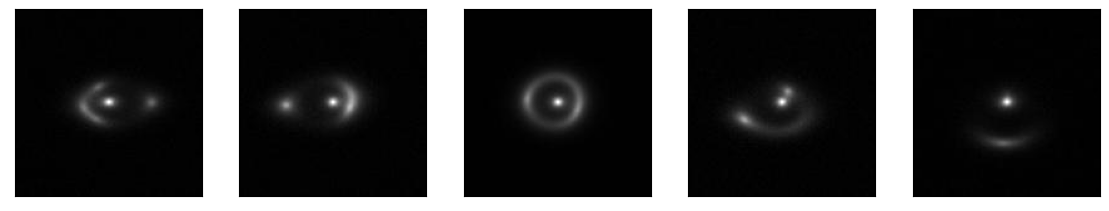

Samples with substructure: 


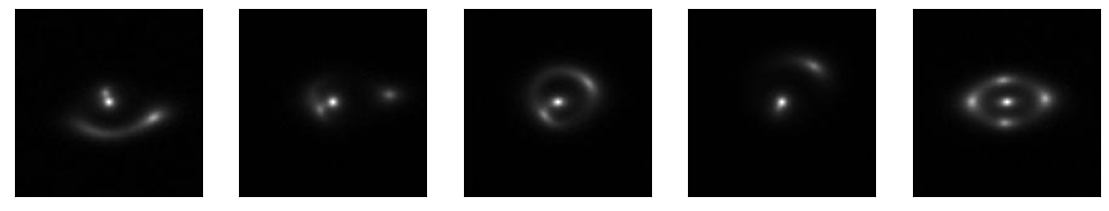

In [4]:
# Define the input paths
train_path1 = './train/no_sub'
train_files1 = [os.path.join(train_path1, f) for f in os.listdir(train_path1) if f.endswith(".jpg")]
train_path2 = './train/sub'
train_files2 = [os.path.join(train_path2, f) for f in os.listdir(train_path2) if f.endswith(".jpg")]

# Number of samples to display per class
n = 5

# Plot the samples 
i = 1
print('Samples with no substructure: ')
plt.rcParams['figure.figsize'] = [14, 14]
for image in train_files1[:n]:
    ax = plt.subplot(2,n,i)
    img = np.array(Image.open(image))
    plt.imshow(img, cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    i += 1
plt.show()

print('Samples with substructure: ')
plt.rcParams['figure.figsize'] = [14, 14]
for image in train_files2[:n]:
    ax = plt.subplot(2,n,i)
    img = np.array(Image.open(image))
    plt.imshow(img, cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    i += 1
plt.show()

#### 1.4 Data preparation

In [5]:
# Create a list of paths to train, validation and test images

classes = []

train_data_path = 'train' 
val_data_path = 'val'
test_data_path = 'test'

train_image_paths = []

for data_path in glob.glob(train_data_path + '/*'):
    classes.append(data_path.split('/')[-1]) 
    train_image_paths.append(glob.glob(data_path + '/*'))

train_image_paths = list(flatten(train_image_paths))
random.shuffle(train_image_paths)

valid_image_paths = []
for data_path in glob.glob(val_data_path + '/*'):
    valid_image_paths.append(glob.glob(data_path + '/*'))

valid_image_paths = list(flatten(valid_image_paths))
random.shuffle(valid_image_paths)

test_image_paths = []
for data_path in glob.glob(test_data_path + '/*'):
    test_image_paths.append(glob.glob(data_path + '/*'))

test_image_paths = list(flatten(test_image_paths))

# Create a mapping between class labels and class numbers

idx_to_class = {i:j for i, j in enumerate(classes)}
class_to_idx = {value:key for key,value in idx_to_class.items()}

In [6]:
# Define a custom dataset to retrieve images and labels

class MyDataset(Dataset):
    def __init__(self, np_file_paths, transform=None):
        self.files = np_file_paths
        self.transform = transform
    
    def __getitem__(self, index):
        image_filepath = self.files[index]
        image = np.array(Image.open(self.files[index]))
        image = torch.from_numpy(image).float()

        label = image_filepath.split('/')[-2]
        label = class_to_idx[label]

        image = image.reshape((1, image.shape[0], image.shape[1]))
        if self.transform is not None:
            image = self.transform(image)
        
        return image, label
    
    def __len__(self):
        return len(self.files)

In [7]:
# Define the trasformations to apply on images

train_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.RandomAffine(degrees=(-20, 20), translate=(0.2, 0.2))
])

valid_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224)
])

test_tranform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224)
])

# Create instances of train, validation and test datasets

train_dataset = MyDataset(train_image_paths, train_transform)
valid_dataset = MyDataset(valid_image_paths, valid_transform)
test_dataset = MyDataset(test_image_paths, test_tranform)

batch_size = 64

# Create data loaders with a batch_size

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [8]:
# Set to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### 2. Training a CoaT model

#### 2.1 Preparing to train the CoaT Model

In [9]:
# Define a utility function to check the accuracy of model on a given loader

def check_accuracy(loader, model, device):
    num_samples = 0
    num_correct_pred = 0
    model.eval()

    y_pred = []
    y_true = []

    with torch.no_grad():
        for (x, y) in loader:
            x = x.to(device)
            y = y.to(device)

            score = model.forward(x)
            val, idx = torch.max(score, dim=1)
            num_correct_pred += (y == idx).sum()
            num_samples += x.shape[0]

            y_pred.extend(list(score.cpu().numpy()))
            y_true.extend((list(y.cpu().numpy())))

        acc = num_correct_pred / num_samples
        y_one_hot = OneHotEncoder().fit_transform(np.array(y_true).reshape(-1, 1)).toarray()
        auc = roc_auc_score(
            y_one_hot.ravel(),
            softmax(np.array(y_pred), axis=1).ravel()
        )

    model.train()
    return acc, auc, y_one_hot, softmax(np.array(y_pred), axis=1)

In [10]:
# Create a directory to checkpoint the model
if not os.path.exists("checkpoint"):
    os.makedirs("checkpoint")

#### 2.2 Define and Train the CoaT model

In [12]:
# Define the hyperparameters and model
num_epochs = 25
lr = 1e-4

model = timm.create_model("coat_lite_small", pretrained=True, num_classes=2, in_chans=1).to(device)
model.default_cfg["input_size"] = (1, 224, 224)
model.default_cfg["num_classes"] = 2

optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

# Define lr scheduler
scheduler = ReduceLROnPlateau(
    optimizer,
    mode="max",
    factor=0.5,
    patience=2,
    threshold=0.0001,
    min_lr=1e-10,
    verbose=True
)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-coat-weights/coat_lite_small-fea1d5a1.pth" to /root/.cache/torch/hub/checkpoints/coat_lite_small-fea1d5a1.pth


In [13]:
# Start a new wandb run
wandb.init(
    project="deeplense-transformers-test",
    config={
        "batch_size": batch_size,
        "learning_rate": lr,
        "architecture": "coat_lite_small",
        "epochs": num_epochs
    }
)

wandb.watch(model, log_freq=100)

wandb: Currently logged in as: yogesh174. Use `wandb login --relogin` to force relogin


[]

In [14]:
max_auc = 0.0

for epoch in range(num_epochs):
    losses_per_batch = []
    start_time = time.time()

    # Mini batch training
    p_bar = tqdm(enumerate(train_loader), leave=False, total=len(train_loader), file=sys.stdout)
    for batch_idx, (x_batch, y_batch) in p_bar:
        # Move data to gpu if available
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        # Forward prop
        scores = model.forward(x_batch)
        
        loss = criterion(scores, y_batch)
        losses_per_batch.append(loss.item())

        # Backward prop
        optimizer.zero_grad()
        loss.backward()

        # Gradient descent step
        optimizer.step()

    # Compute acc and loss
    cur_acc, auc, _, _ = check_accuracy(valid_loader, model, device)
    mean_loss = sum(losses_per_batch) / len(losses_per_batch)

    # lr scheduler
    scheduler.step(auc)

    # Save best model
    if auc > max_auc:
        checkpoint = {
            "model": model.state_dict(),
            "optimizer": optimizer.state_dict()
        }
        print(f"epoch: [{epoch + 1}/{num_epochs}], ", end="")

        checkpoint_file = f"./checkpoint/best_model.pt"
        print(f"Saving model ...")
        torch.save(checkpoint, checkpoint_file)
        max_auc = auc

    # Print log
    end_time = time.time()
    print(f"epoch: [{epoch + 1}/{num_epochs}], "
          f"loss: {mean_loss:.8f}, "
          f"val acc: {cur_acc.item():.4f}, "
          f"val auc: {auc:.4f}, "
          f"time used: {(end_time - start_time)/60:.4f}m")

    # Send log
    wandb.log({'accuracy': cur_acc.item(), 'epoch': epoch, 'auc': auc, 'time': (end_time - start_time)/60})

epoch: [1/25], Saving model ...                  
epoch: [1/25], loss: 0.69589182, val acc: 0.4970, val auc: 0.4928, time used: 4.8514m
epoch: [2/25], Saving model ...                  
epoch: [2/25], loss: 0.69288886, val acc: 0.5000, val auc: 0.5421, time used: 4.7958m
epoch: [3/25], loss: 0.69593030, val acc: 0.5000, val auc: 0.5232, time used: 4.7780m
epoch: [4/25], Saving model ...                  
epoch: [4/25], loss: 0.69225651, val acc: 0.5000, val auc: 0.6085, time used: 4.7862m
epoch: [5/25], Saving model ...                  
epoch: [5/25], loss: 0.66863817, val acc: 0.7810, val auc: 0.8548, time used: 4.7860m
epoch: [6/25], Saving model ...                  
epoch: [6/25], loss: 0.40118853, val acc: 0.9340, val auc: 0.9831, time used: 4.8005m
epoch: [7/25], Saving model ...                  
epoch: [7/25], loss: 0.14670506, val acc: 0.9450, val auc: 0.9903, time used: 4.7989m
epoch: [8/25], Saving model ...                  
epoch: [8/25], loss: 0.10354263, val acc: 0.9790

### 3. Testing

#### 3.1 Load the best CoaT model

In [15]:
# Load the best model

model = timm.create_model("coat_lite_small", pretrained=False, num_classes=2, in_chans=1).to(device)
model.default_cfg["input_size"] = (1, 224, 224)
model.default_cfg["num_classes"] = 2

optimizer = optim.Adam(model.parameters(), lr=lr)

pretrained_model = "./checkpoint/best_model.pt"
checkpoint = torch.load(pretrained_model)
model.load_state_dict(checkpoint["model"])
optimizer.load_state_dict(checkpoint["optimizer"])

#### 3.2 Test the model on testing data and plot ROC Curves & compute AUC

acc: 0.9900000691413879, auc: 0.9997039999999999


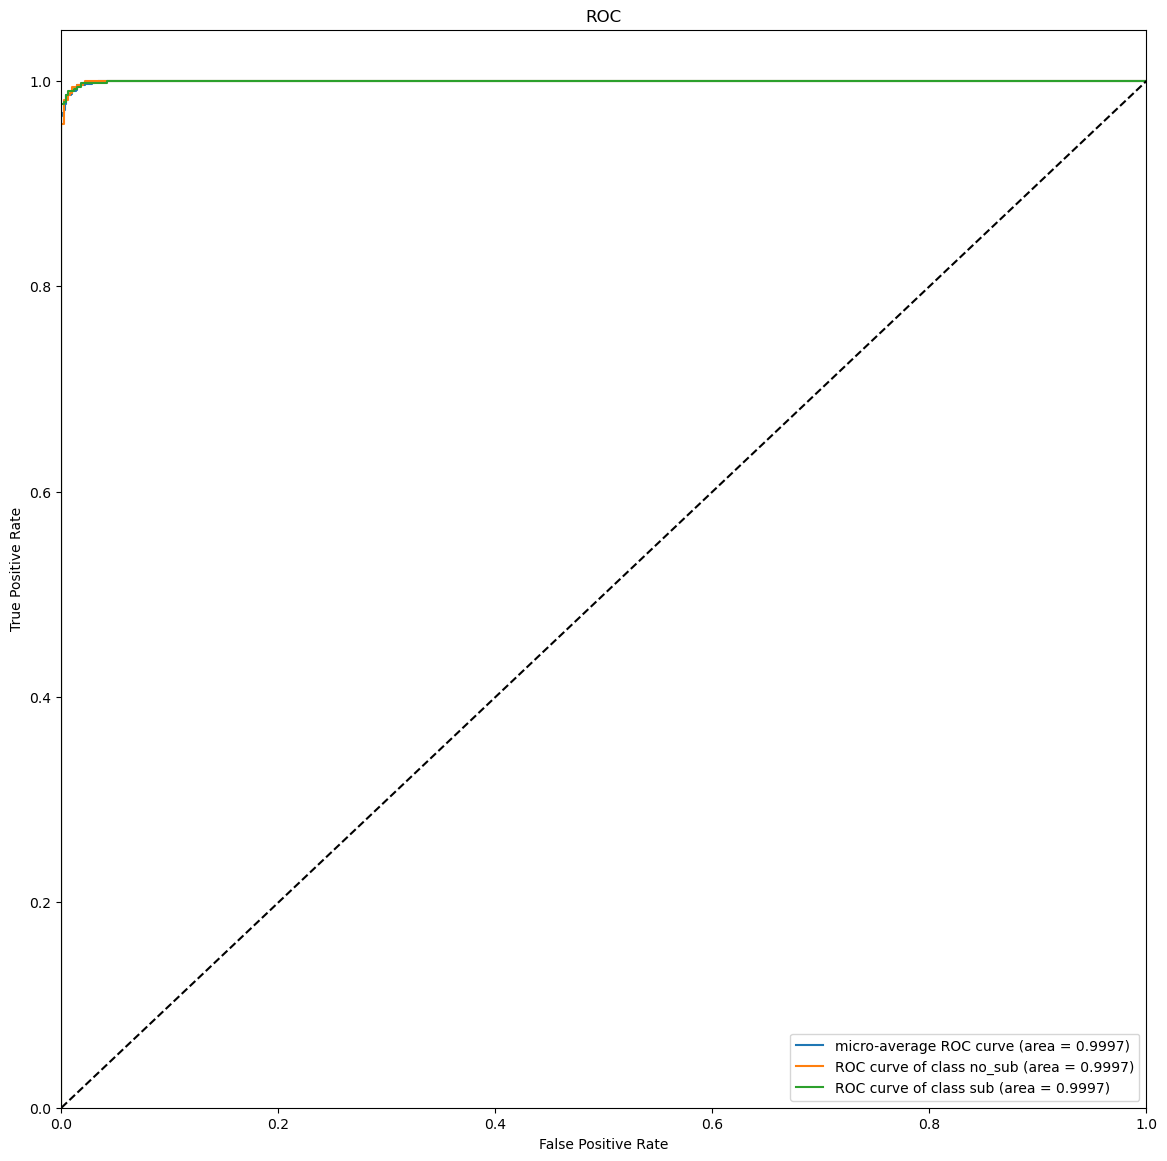

In [16]:
acc, auc, y_true, y_pred = check_accuracy(test_loader, model, device)
print(f"acc: {acc.item()}, auc: {auc}")

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_pred.ravel())
roc_auc["micro"] = metrics.auc(fpr["micro"], tpr["micro"])


plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.4f})'
               ''.format(roc_auc["micro"]))
for i in range(len(classes)):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class '+ idx_to_class[i]+ ' (area = {0:0.4f})'
                                   ''.format(roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

### 4. Results

Validation Accuracy: 99.80% \
Validation AUC: **1.00**

Test Accuracy: 99% \
Test AUC: **0.9997**